In [11]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [12]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

## Going Deeper into fastai's Layered API

In [13]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [14]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

In [46]:
path

Path('C:/Users/C1602/.fastai/data/imdb')

In [48]:
TextBlock.from_folder(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


### Transforms

In [15]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [16]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...]

In [17]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,    8,  318,  217,    8,  478,   10,    8, 6386,   69])

In [18]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has']

In [19]:
tok.decode(nums_dec)

'xxbos xxmaj once again xxmaj mr . xxmaj costner has'

In [20]:
tok((txts[0], txts[1]))

((#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...],
 (#314) ['xxbos','xxmaj','this','is','an','example','of','why','the','majority'...])

### Writing Your Own Transform

In [21]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [22]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

In [23]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [59]:
print(issubclass(NormalizeMean, Transform))

True


In [24]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

In [ ]:
class CustomTransform(Transform):
    def __init__(self, vocab=None, min_freq=3, max_vocab=60000, special_toks=None):
        self.vocab=vocab
        self.min_freq=min_freq
        self.max_vocab=max_vocab
        self.special_toks=special_toks
        self.o2i=None
    def setups(self,dsets):
        self.dsets=dsets
        count=Counter(p for o in self.dsets for p in o)
        self.vocab = make_vocab(count, min_freq=self.min_freq, max_vocab=self.max_vocab,special_toks=self.special_toks)
        self.o2i={i:j for i,j in enumerate(self.vocab)}
    def encodes(self,o):
        return TensorText(tensor([self.o2i[i] for i in o]))
    def decodes(self, o): 
        return L(self.vocab[o_] for o_ in o)


### Pipeline

In [25]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,  318,  217,    8,  478,   10,    8, 6386,   69, 2800,   61,   12,   26,   29,  213, 1357,   98, 2502,   10])

In [26]:
tfms.decode(t)[:100]

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessar'

## TfmdLists and Datasets: Transformed Collections

### TfmdLists

In [27]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [60]:
files

(#7390) [Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

In [28]:
t = tls[0]; t[:20]

TensorText([   2,    8,  302,  195,    8,  500,   10,    8, 5580,   62, 3409,   61,   13,   30,   29,  249, 1144,   94, 1715,   10])

In [29]:
tls.decode(t)[:100]

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessar'

In [30]:
tls.show(t)

xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do to kee

In [31]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [32]:
tls.valid[0][:20]

TensorText([    2,     8,  2304,     8,  9471,  2294,     9,   144,    54,     8,  4995,    54,     8,   118,    97,     8, 16996,     0,    27,    68])

In [33]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [34]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [35]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

### Datasets

In [36]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([   2,    8,  302,  195,    8,  500,   10,    8, 5580,   62, 3409,   61,   13,   30,   29,  249, 1144,   94, 1715,   10]),
 TensorCategory(0))

In [37]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,     8,  2304,     8,  9471,  2294,     9,   144,    54,     8,  4995,    54,     8,   118,    97,     8, 16996,     0,    27,    68]),
 TensorCategory(1))

In [38]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj kate xxmaj beckinsale steals the show ! xxmaj bravo ! xxmaj too bad xxmaj knightly xxunk as good looking as xxmaj jeremy xxmaj northam . xxmaj mark xxmaj strong did a fabulous job . xxmaj bernard xxmaj hepton was perfect as xxmaj xxunk father . i love the end scene ( which is an addition to the novel - but well written ) when the harvest is in and xxmaj knightly xxunk with his workers and high society friends . xxmaj emma must show that she accepts this now . xxmaj she is a changed woman . xxmaj that is too much too quick , but xxup ok . xxmaj i 'll buy into it . xxmaj samantha xxmaj bond plays xxmaj emma 's ex - governess and confidant . xxmaj she is wonderful . just as i would have imagined her . i believe that when the xxup uk does a xxmaj jane xxmaj austen its the best . xxmaj american versions of xxmaj english literature are done for money and not for quality . xxmaj see this one !",
 'pos')

In [39]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [40]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [41]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

## Applying the Mid-Level Data API: SiamesePair

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [2]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

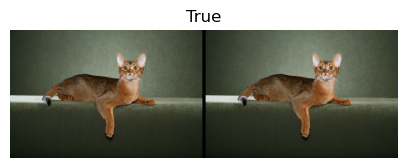

In [3]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

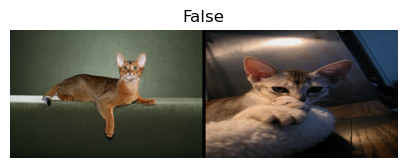

In [4]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

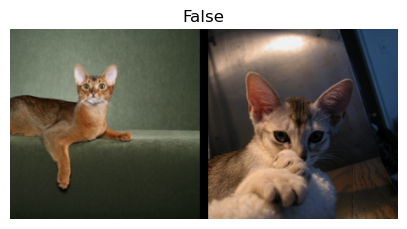

In [5]:
s2 = Resize(224)(s1)
s2.show();

In [6]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [7]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

In [14]:
tfm.lbl2files

{'Abyssinian': (#200) [Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...],
 'american_bulldog': (#200) [Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/american_bulldog_10.jpg'),Path('C:/Users/C1602/.fastai/data/oxford-iiit-pet/images/american_bulldog_100.jpg')

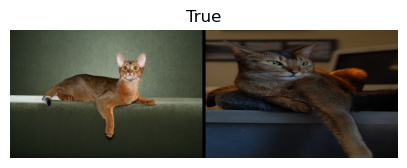

In [12]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

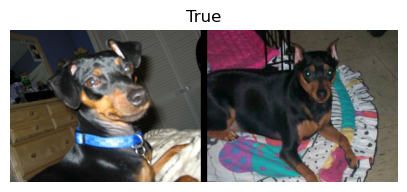

In [9]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [10]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

## Conclusion

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?
1. Why does a `Transform` have a `decode` method? What does it do?
1. Why does a `Transform` have a `setup` method? What does it do?
1. How does a `Transform` work when called on a tuple?
1. Which methods do you need to implement when writing your own `Transform`?
1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and that can decode that behavior. Try not to peek!
1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.
1. What is a `Pipeline`?
1. What is a `TfmdLists`? 
1. What is a `Datasets`? How is it different from a `TfmdLists`?
1. Why are `TfmdLists` and `Datasets` named with an "s"?
1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?
1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

### Further Research

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.
1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.

In [15]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

## Understanding fastai's Applications: Wrap Up

Congratulations—you've completed all of the chapters in this book that cover the key practical parts of training models and using deep learning! You know how to use all of fastai's built-in applications, and how to customize them using the data block API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to make sure your creations help improve society too.)

The knowledge you already have is enough to create full working prototypes of many types of neural network applications. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system that's well adapted to them.

In the rest of this book we will be pulling apart those applications, piece by piece, to understand the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is what allows you to inspect and debug models that you build and create new applications that are customized for your particular projects.